# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [11]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
ALPHA = 0.2
KEEP = 0.5

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

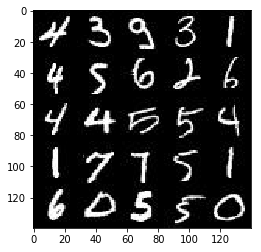

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

In [3]:
import matplotlib
print(matplotlib.__version__)

2.0.0


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

(25, 28, 28, 3)


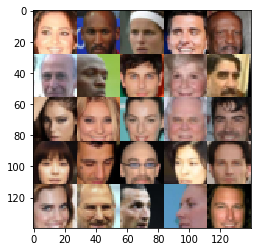

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
print(celeba_images.shape)
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_z')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(None), name='learning_rate')

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [7]:
def l_relu(x):
    return tf.maximum(x * ALPHA, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    kinit = tf.random_normal_initializer(stddev=0.02)
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input celeb_a (28, 28, 3), (mnist 28, 28, 1)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = l_relu(x1)
        x1 = tf.nn.dropout(x1, KEEP)
        #Current Size (14, 14, 64)
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = l_relu(x2)
        x2 = tf.nn.dropout(x2, KEEP)
        #Current Size (7, 7, 128)
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = l_relu(x3)
        x3 = tf.nn.dropout(x3, KEEP)
        #Current Size (4, 4, 256)
        flat = tf.reshape(x3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return (out, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input 
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    not_is_train = not is_train
    kinit = tf.random_normal_initializer(stddev=0.02)
    with tf.variable_scope('generator', reuse=not_is_train):
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = l_relu(x1)
         # First Layer Complete, size is (7, 7, 256)
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = l_relu(x2)
        x2 = tf.nn.dropout(x2, KEEP)
        # Second layer complete, size is (7, 7, 128)
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = l_relu(x3)
        x3 = tf.nn.dropout(x3, KEEP)
        # Third layer complete, size is (14, 14, 64)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', activation=None)
        out = tf.tanh(logits)
        # Final layer complete, size is (28, 28, out_channel_dim)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=d_logits_real, labels=tf.ones_like(d_model_real * (1 - 0.1))))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return(d_loss, g_loss)
    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the 
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    print('LEARNING RATE', learning_rate)
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)   
    return (d_train_opt, g_train_opt)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

LEARNING RATE 0.001
Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         print_every = 10, show_every = 100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #Build Model 
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    #Run The Model    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                #Generate noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #Run optimizers
                _ = sess.run(d_opt, feed_dict = {input_real : batch_images, input_z : batch_z})
                _ = sess.run(g_opt, feed_dict = {input_z : batch_z})
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z : batch_z, input_real : batch_images})
                    train_loss_g = g_loss.eval({input_z : batch_z})
                    print('Epoch {} / {}'.format(epoch_i + 1, epoch_count),
                          'G Loss: {:.4f}'.format(train_loss_g),
                          'D Loss: {:.4f}'.format(train_loss_d))
                if steps % (show_every) == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                    
             
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

LEARNING RATE 0.0002
Epoch 1 / 2 G Loss: 0.5932 D Loss: 1.2407
Epoch 1 / 2 G Loss: 0.6977 D Loss: 1.3384
Epoch 1 / 2 G Loss: 0.5639 D Loss: 1.4320
Epoch 1 / 2 G Loss: 0.7037 D Loss: 1.3116
Epoch 1 / 2 G Loss: 0.7192 D Loss: 1.3340
Epoch 1 / 2 G Loss: 0.7074 D Loss: 1.3208
Epoch 1 / 2 G Loss: 0.7102 D Loss: 1.4154
Epoch 1 / 2 G Loss: 0.6548 D Loss: 1.4074
Epoch 1 / 2 G Loss: 0.7301 D Loss: 1.2906
Epoch 1 / 2 G Loss: 0.7323 D Loss: 1.3355


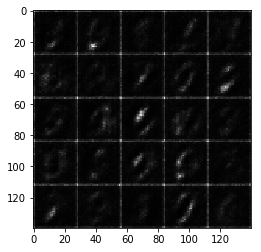

Epoch 1 / 2 G Loss: 0.6763 D Loss: 1.3600
Epoch 1 / 2 G Loss: 0.7089 D Loss: 1.3536
Epoch 1 / 2 G Loss: 0.6919 D Loss: 1.3563
Epoch 1 / 2 G Loss: 0.6902 D Loss: 1.4117
Epoch 1 / 2 G Loss: 0.6824 D Loss: 1.3798
Epoch 1 / 2 G Loss: 0.6619 D Loss: 1.4132
Epoch 1 / 2 G Loss: 0.6909 D Loss: 1.3885
Epoch 1 / 2 G Loss: 0.6953 D Loss: 1.3819
Epoch 1 / 2 G Loss: 0.7325 D Loss: 1.3613
Epoch 1 / 2 G Loss: 0.7289 D Loss: 1.2731


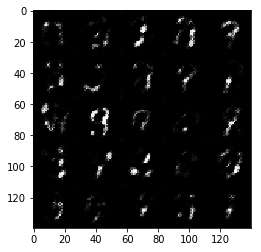

Epoch 1 / 2 G Loss: 0.7231 D Loss: 1.3589
Epoch 1 / 2 G Loss: 0.7378 D Loss: 1.2336
Epoch 1 / 2 G Loss: 0.7502 D Loss: 1.2897
Epoch 1 / 2 G Loss: 0.7078 D Loss: 1.3309
Epoch 1 / 2 G Loss: 0.6718 D Loss: 1.3931
Epoch 1 / 2 G Loss: 0.6875 D Loss: 1.4302
Epoch 1 / 2 G Loss: 0.7015 D Loss: 1.4257
Epoch 1 / 2 G Loss: 0.6965 D Loss: 1.3236
Epoch 1 / 2 G Loss: 0.5295 D Loss: 1.4064
Epoch 1 / 2 G Loss: 0.7201 D Loss: 1.2960


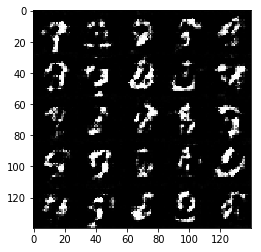

Epoch 1 / 2 G Loss: 0.6747 D Loss: 1.4673
Epoch 1 / 2 G Loss: 0.7192 D Loss: 1.3137
Epoch 1 / 2 G Loss: 0.8954 D Loss: 1.2671
Epoch 1 / 2 G Loss: 0.8288 D Loss: 1.2439
Epoch 1 / 2 G Loss: 0.6247 D Loss: 1.2783
Epoch 1 / 2 G Loss: 0.9000 D Loss: 1.2883
Epoch 1 / 2 G Loss: 1.0379 D Loss: 1.1148
Epoch 1 / 2 G Loss: 1.1816 D Loss: 1.2984
Epoch 1 / 2 G Loss: 0.6293 D Loss: 1.2384
Epoch 1 / 2 G Loss: 0.9020 D Loss: 1.3062


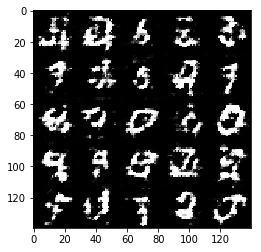

Epoch 1 / 2 G Loss: 0.9552 D Loss: 1.0984
Epoch 1 / 2 G Loss: 0.7199 D Loss: 1.1673
Epoch 1 / 2 G Loss: 0.8077 D Loss: 1.3798
Epoch 1 / 2 G Loss: 1.0567 D Loss: 1.1476
Epoch 1 / 2 G Loss: 0.7756 D Loss: 1.2338
Epoch 1 / 2 G Loss: 1.0862 D Loss: 1.3833
Epoch 2 / 2 G Loss: 0.8241 D Loss: 1.1726
Epoch 2 / 2 G Loss: 0.7838 D Loss: 1.2400
Epoch 2 / 2 G Loss: 0.6811 D Loss: 1.3823
Epoch 2 / 2 G Loss: 0.9322 D Loss: 1.2204


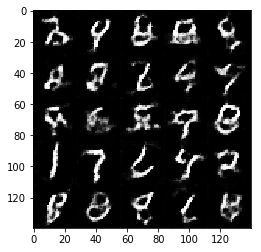

Epoch 2 / 2 G Loss: 0.8350 D Loss: 1.2718
Epoch 2 / 2 G Loss: 0.6650 D Loss: 1.3127
Epoch 2 / 2 G Loss: 0.7689 D Loss: 1.2499
Epoch 2 / 2 G Loss: 0.5499 D Loss: 1.3446
Epoch 2 / 2 G Loss: 0.7980 D Loss: 1.2782
Epoch 2 / 2 G Loss: 0.8126 D Loss: 1.2827
Epoch 2 / 2 G Loss: 0.8956 D Loss: 1.3213
Epoch 2 / 2 G Loss: 0.6320 D Loss: 1.3820
Epoch 2 / 2 G Loss: 0.7486 D Loss: 1.3101
Epoch 2 / 2 G Loss: 0.8231 D Loss: 1.2501


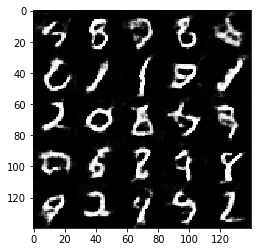

Epoch 2 / 2 G Loss: 0.6693 D Loss: 1.3535
Epoch 2 / 2 G Loss: 0.7719 D Loss: 1.2489
Epoch 2 / 2 G Loss: 0.8953 D Loss: 1.2396
Epoch 2 / 2 G Loss: 0.7481 D Loss: 1.3545
Epoch 2 / 2 G Loss: 0.7239 D Loss: 1.3317
Epoch 2 / 2 G Loss: 0.8069 D Loss: 1.2997
Epoch 2 / 2 G Loss: 0.8138 D Loss: 1.2744
Epoch 2 / 2 G Loss: 0.7388 D Loss: 1.2847
Epoch 2 / 2 G Loss: 0.6582 D Loss: 1.3906
Epoch 2 / 2 G Loss: 0.7647 D Loss: 1.3777


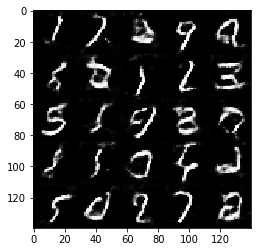

Epoch 2 / 2 G Loss: 0.8000 D Loss: 1.3615
Epoch 2 / 2 G Loss: 0.7580 D Loss: 1.2817
Epoch 2 / 2 G Loss: 0.8075 D Loss: 1.2434
Epoch 2 / 2 G Loss: 0.7318 D Loss: 1.2530
Epoch 2 / 2 G Loss: 0.7663 D Loss: 1.2688
Epoch 2 / 2 G Loss: 0.8705 D Loss: 1.2269
Epoch 2 / 2 G Loss: 0.7969 D Loss: 1.2918
Epoch 2 / 2 G Loss: 0.6804 D Loss: 1.3196
Epoch 2 / 2 G Loss: 0.7409 D Loss: 1.2888
Epoch 2 / 2 G Loss: 0.7121 D Loss: 1.2164


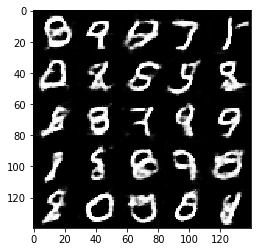

Epoch 2 / 2 G Loss: 0.7711 D Loss: 1.3139
Epoch 2 / 2 G Loss: 0.7512 D Loss: 1.2407
Epoch 2 / 2 G Loss: 0.7821 D Loss: 1.2839
Epoch 2 / 2 G Loss: 0.8048 D Loss: 1.3847
Epoch 2 / 2 G Loss: 0.9079 D Loss: 1.3891
Epoch 2 / 2 G Loss: 0.6958 D Loss: 1.2894
Epoch 2 / 2 G Loss: 0.7029 D Loss: 1.3077
Epoch 2 / 2 G Loss: 0.7977 D Loss: 1.3684
Epoch 2 / 2 G Loss: 0.8520 D Loss: 1.3264
Epoch 2 / 2 G Loss: 0.7016 D Loss: 1.2829


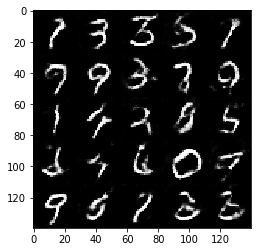

Epoch 2 / 2 G Loss: 0.7539 D Loss: 1.3060
Epoch 2 / 2 G Loss: 0.8036 D Loss: 1.3003
Epoch 2 / 2 G Loss: 0.7324 D Loss: 1.3855


In [24]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
ALPHA = 0.2
KEEP = 0.9

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

LEARNING RATE 0.0002
Epoch 1 / 1 G Loss: 0.7802 D Loss: 1.0255
Epoch 1 / 1 G Loss: 1.8595 D Loss: 0.4600
Epoch 1 / 1 G Loss: 2.2591 D Loss: 0.3717
Epoch 1 / 1 G Loss: 0.8630 D Loss: 0.9150
Epoch 1 / 1 G Loss: 1.2348 D Loss: 0.9692
Epoch 1 / 1 G Loss: 1.4213 D Loss: 0.8482
Epoch 1 / 1 G Loss: 1.6929 D Loss: 0.7929
Epoch 1 / 1 G Loss: 1.2584 D Loss: 0.7629
Epoch 1 / 1 G Loss: 2.1087 D Loss: 0.6837
Epoch 1 / 1 G Loss: 2.9267 D Loss: 0.8103


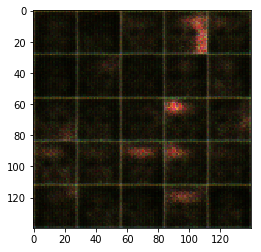

Epoch 1 / 1 G Loss: 1.6827 D Loss: 0.5166
Epoch 1 / 1 G Loss: 2.5114 D Loss: 0.4995
Epoch 1 / 1 G Loss: 1.5875 D Loss: 0.5745
Epoch 1 / 1 G Loss: 2.4201 D Loss: 0.6677
Epoch 1 / 1 G Loss: 1.0407 D Loss: 0.9119
Epoch 1 / 1 G Loss: 2.0098 D Loss: 0.7651
Epoch 1 / 1 G Loss: 1.7824 D Loss: 0.7296
Epoch 1 / 1 G Loss: 1.1816 D Loss: 0.9773
Epoch 1 / 1 G Loss: 1.6181 D Loss: 0.8892
Epoch 1 / 1 G Loss: 1.1927 D Loss: 0.8910


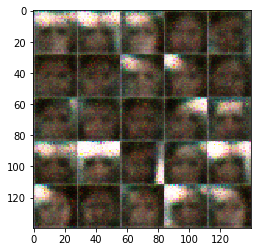

Epoch 1 / 1 G Loss: 1.3143 D Loss: 0.9474
Epoch 1 / 1 G Loss: 1.1631 D Loss: 1.0356
Epoch 1 / 1 G Loss: 1.1371 D Loss: 1.0373
Epoch 1 / 1 G Loss: 1.2963 D Loss: 0.9011
Epoch 1 / 1 G Loss: 1.4768 D Loss: 0.9756
Epoch 1 / 1 G Loss: 1.3246 D Loss: 1.0935
Epoch 1 / 1 G Loss: 1.2076 D Loss: 1.0135
Epoch 1 / 1 G Loss: 1.6100 D Loss: 1.2485
Epoch 1 / 1 G Loss: 1.3824 D Loss: 0.8719
Epoch 1 / 1 G Loss: 1.1950 D Loss: 0.9854


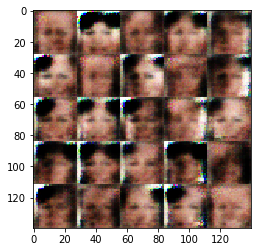

Epoch 1 / 1 G Loss: 1.1975 D Loss: 1.0389
Epoch 1 / 1 G Loss: 0.8669 D Loss: 1.1382
Epoch 1 / 1 G Loss: 0.4569 D Loss: 1.3126
Epoch 1 / 1 G Loss: 1.4106 D Loss: 1.3789
Epoch 1 / 1 G Loss: 0.9274 D Loss: 1.0005
Epoch 1 / 1 G Loss: 0.8859 D Loss: 0.9730
Epoch 1 / 1 G Loss: 0.7696 D Loss: 1.3088
Epoch 1 / 1 G Loss: 1.2209 D Loss: 1.1669
Epoch 1 / 1 G Loss: 1.0144 D Loss: 1.0188
Epoch 1 / 1 G Loss: 0.8563 D Loss: 1.3168


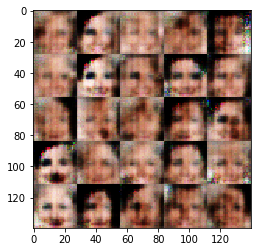

Epoch 1 / 1 G Loss: 0.6793 D Loss: 1.3552
Epoch 1 / 1 G Loss: 0.9713 D Loss: 1.0827
Epoch 1 / 1 G Loss: 0.9774 D Loss: 1.1347
Epoch 1 / 1 G Loss: 0.8030 D Loss: 1.2206
Epoch 1 / 1 G Loss: 0.8067 D Loss: 1.1855
Epoch 1 / 1 G Loss: 1.1093 D Loss: 1.2977
Epoch 1 / 1 G Loss: 1.2586 D Loss: 1.1586
Epoch 1 / 1 G Loss: 0.9993 D Loss: 1.1332
Epoch 1 / 1 G Loss: 0.7945 D Loss: 1.1933
Epoch 1 / 1 G Loss: 0.8129 D Loss: 1.1167


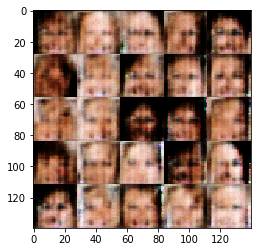

Epoch 1 / 1 G Loss: 0.9246 D Loss: 1.2120
Epoch 1 / 1 G Loss: 0.8567 D Loss: 1.2509
Epoch 1 / 1 G Loss: 0.7868 D Loss: 1.1450
Epoch 1 / 1 G Loss: 1.0198 D Loss: 1.3084
Epoch 1 / 1 G Loss: 0.9422 D Loss: 1.1304
Epoch 1 / 1 G Loss: 0.7154 D Loss: 1.2586
Epoch 1 / 1 G Loss: 1.1259 D Loss: 1.2531
Epoch 1 / 1 G Loss: 0.8342 D Loss: 1.1209
Epoch 1 / 1 G Loss: 0.8349 D Loss: 1.2953
Epoch 1 / 1 G Loss: 0.9540 D Loss: 1.2587


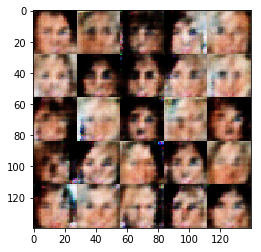

Epoch 1 / 1 G Loss: 1.0592 D Loss: 1.1561
Epoch 1 / 1 G Loss: 0.8800 D Loss: 1.2480
Epoch 1 / 1 G Loss: 0.9915 D Loss: 1.2774
Epoch 1 / 1 G Loss: 0.6765 D Loss: 1.2708
Epoch 1 / 1 G Loss: 1.1447 D Loss: 1.2558
Epoch 1 / 1 G Loss: 0.8103 D Loss: 1.2840
Epoch 1 / 1 G Loss: 0.8484 D Loss: 1.1990
Epoch 1 / 1 G Loss: 0.6707 D Loss: 1.2328
Epoch 1 / 1 G Loss: 0.9105 D Loss: 1.1672
Epoch 1 / 1 G Loss: 1.0239 D Loss: 1.2022


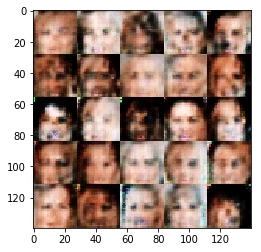

Epoch 1 / 1 G Loss: 0.6660 D Loss: 1.2324
Epoch 1 / 1 G Loss: 1.1497 D Loss: 1.2313
Epoch 1 / 1 G Loss: 0.8917 D Loss: 1.2915
Epoch 1 / 1 G Loss: 0.8022 D Loss: 1.1573
Epoch 1 / 1 G Loss: 0.9517 D Loss: 1.2171
Epoch 1 / 1 G Loss: 0.8439 D Loss: 1.2783
Epoch 1 / 1 G Loss: 0.7380 D Loss: 1.2629
Epoch 1 / 1 G Loss: 0.8755 D Loss: 1.2600
Epoch 1 / 1 G Loss: 0.9131 D Loss: 1.2817
Epoch 1 / 1 G Loss: 0.7419 D Loss: 1.2144


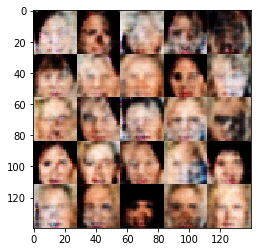

Epoch 1 / 1 G Loss: 0.9378 D Loss: 1.2462
Epoch 1 / 1 G Loss: 0.9249 D Loss: 1.1711
Epoch 1 / 1 G Loss: 0.7070 D Loss: 1.2367
Epoch 1 / 1 G Loss: 0.7734 D Loss: 1.3170
Epoch 1 / 1 G Loss: 0.8732 D Loss: 1.2627
Epoch 1 / 1 G Loss: 1.0953 D Loss: 1.3087
Epoch 1 / 1 G Loss: 0.8711 D Loss: 1.2313
Epoch 1 / 1 G Loss: 0.6904 D Loss: 1.2828
Epoch 1 / 1 G Loss: 0.9130 D Loss: 1.1533
Epoch 1 / 1 G Loss: 0.8712 D Loss: 1.2425


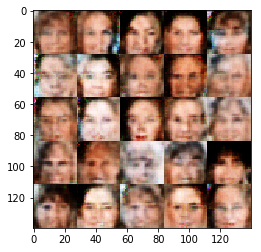

Epoch 1 / 1 G Loss: 0.7442 D Loss: 1.3239
Epoch 1 / 1 G Loss: 0.5589 D Loss: 1.3289
Epoch 1 / 1 G Loss: 0.6231 D Loss: 1.2624
Epoch 1 / 1 G Loss: 0.9638 D Loss: 1.2622
Epoch 1 / 1 G Loss: 0.8086 D Loss: 1.1911
Epoch 1 / 1 G Loss: 0.9186 D Loss: 1.2074
Epoch 1 / 1 G Loss: 0.6113 D Loss: 1.2812
Epoch 1 / 1 G Loss: 0.9233 D Loss: 1.1851
Epoch 1 / 1 G Loss: 0.7722 D Loss: 1.2542
Epoch 1 / 1 G Loss: 0.8606 D Loss: 1.2300


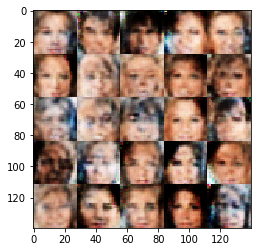

Epoch 1 / 1 G Loss: 0.9451 D Loss: 1.2469
Epoch 1 / 1 G Loss: 0.7272 D Loss: 1.2328
Epoch 1 / 1 G Loss: 0.6804 D Loss: 1.2510
Epoch 1 / 1 G Loss: 0.9088 D Loss: 1.1836
Epoch 1 / 1 G Loss: 1.0234 D Loss: 1.2074
Epoch 1 / 1 G Loss: 0.6295 D Loss: 1.2727
Epoch 1 / 1 G Loss: 0.9754 D Loss: 1.2884
Epoch 1 / 1 G Loss: 0.7761 D Loss: 1.2371
Epoch 1 / 1 G Loss: 0.7700 D Loss: 1.2218
Epoch 1 / 1 G Loss: 0.8532 D Loss: 1.2748


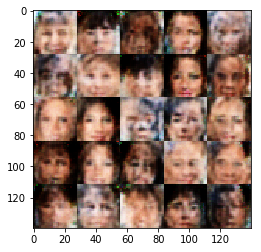

Epoch 1 / 1 G Loss: 0.7616 D Loss: 1.2440
Epoch 1 / 1 G Loss: 0.7823 D Loss: 1.2792
Epoch 1 / 1 G Loss: 0.6986 D Loss: 1.2264
Epoch 1 / 1 G Loss: 0.8004 D Loss: 1.1813
Epoch 1 / 1 G Loss: 0.9930 D Loss: 1.2026
Epoch 1 / 1 G Loss: 0.8753 D Loss: 1.2578
Epoch 1 / 1 G Loss: 0.7712 D Loss: 1.2512
Epoch 1 / 1 G Loss: 0.7642 D Loss: 1.4136
Epoch 1 / 1 G Loss: 0.7745 D Loss: 1.2136
Epoch 1 / 1 G Loss: 0.7494 D Loss: 1.2769


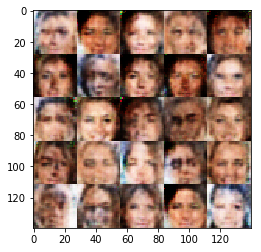

Epoch 1 / 1 G Loss: 0.6380 D Loss: 1.2547
Epoch 1 / 1 G Loss: 0.8232 D Loss: 1.3358
Epoch 1 / 1 G Loss: 0.9867 D Loss: 1.2635
Epoch 1 / 1 G Loss: 0.7634 D Loss: 1.3086
Epoch 1 / 1 G Loss: 0.8093 D Loss: 1.2212
Epoch 1 / 1 G Loss: 0.8674 D Loss: 1.2837
Epoch 1 / 1 G Loss: 1.1785 D Loss: 1.2137
Epoch 1 / 1 G Loss: 0.6206 D Loss: 1.3182
Epoch 1 / 1 G Loss: 0.6549 D Loss: 1.3434
Epoch 1 / 1 G Loss: 0.9260 D Loss: 1.2840


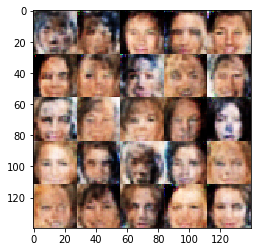

Epoch 1 / 1 G Loss: 0.8851 D Loss: 1.2663
Epoch 1 / 1 G Loss: 0.8938 D Loss: 1.2351
Epoch 1 / 1 G Loss: 0.7245 D Loss: 1.2561
Epoch 1 / 1 G Loss: 0.9221 D Loss: 1.2661
Epoch 1 / 1 G Loss: 0.8548 D Loss: 1.3248
Epoch 1 / 1 G Loss: 0.9841 D Loss: 1.2352
Epoch 1 / 1 G Loss: 0.6463 D Loss: 1.2508
Epoch 1 / 1 G Loss: 0.8154 D Loss: 1.2969
Epoch 1 / 1 G Loss: 0.8055 D Loss: 1.2712
Epoch 1 / 1 G Loss: 0.6504 D Loss: 1.3014


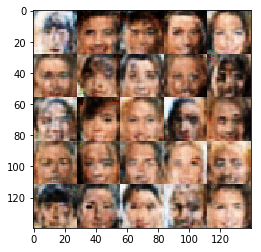

Epoch 1 / 1 G Loss: 0.7791 D Loss: 1.2027
Epoch 1 / 1 G Loss: 0.8655 D Loss: 1.3669
Epoch 1 / 1 G Loss: 0.8467 D Loss: 1.2515
Epoch 1 / 1 G Loss: 1.0549 D Loss: 1.2519
Epoch 1 / 1 G Loss: 0.7442 D Loss: 1.3076
Epoch 1 / 1 G Loss: 0.8854 D Loss: 1.3118
Epoch 1 / 1 G Loss: 1.0653 D Loss: 1.2957
Epoch 1 / 1 G Loss: 0.9626 D Loss: 1.2890
Epoch 1 / 1 G Loss: 0.7618 D Loss: 1.3279
Epoch 1 / 1 G Loss: 0.6984 D Loss: 1.2926


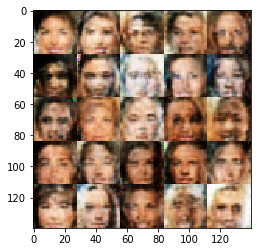

Epoch 1 / 1 G Loss: 0.8214 D Loss: 1.2887
Epoch 1 / 1 G Loss: 0.9378 D Loss: 1.2292
Epoch 1 / 1 G Loss: 0.8025 D Loss: 1.2836
Epoch 1 / 1 G Loss: 0.8290 D Loss: 1.2595
Epoch 1 / 1 G Loss: 0.8609 D Loss: 1.2596
Epoch 1 / 1 G Loss: 0.7910 D Loss: 1.2855
Epoch 1 / 1 G Loss: 0.5955 D Loss: 1.3650
Epoch 1 / 1 G Loss: 0.7394 D Loss: 1.2864
Epoch 1 / 1 G Loss: 0.7274 D Loss: 1.2687
Epoch 1 / 1 G Loss: 0.8537 D Loss: 1.2988


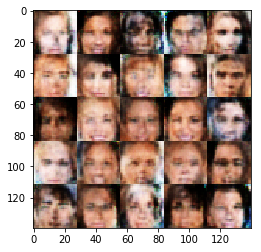

Epoch 1 / 1 G Loss: 0.9585 D Loss: 1.2825
Epoch 1 / 1 G Loss: 0.8301 D Loss: 1.3634
Epoch 1 / 1 G Loss: 0.7062 D Loss: 1.3221
Epoch 1 / 1 G Loss: 0.7848 D Loss: 1.2911
Epoch 1 / 1 G Loss: 0.7139 D Loss: 1.3264
Epoch 1 / 1 G Loss: 0.6713 D Loss: 1.3064
Epoch 1 / 1 G Loss: 0.7034 D Loss: 1.2356
Epoch 1 / 1 G Loss: 0.9062 D Loss: 1.2830
Epoch 1 / 1 G Loss: 0.7529 D Loss: 1.3746
Epoch 1 / 1 G Loss: 0.8044 D Loss: 1.3148


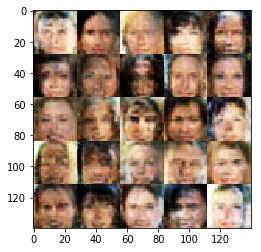

Epoch 1 / 1 G Loss: 0.8643 D Loss: 1.2341
Epoch 1 / 1 G Loss: 0.9056 D Loss: 1.4161
Epoch 1 / 1 G Loss: 0.8135 D Loss: 1.2620
Epoch 1 / 1 G Loss: 0.8320 D Loss: 1.2898
Epoch 1 / 1 G Loss: 0.5634 D Loss: 1.3424
Epoch 1 / 1 G Loss: 0.8642 D Loss: 1.3167
Epoch 1 / 1 G Loss: 0.7507 D Loss: 1.2880
Epoch 1 / 1 G Loss: 0.8839 D Loss: 1.3001
Epoch 1 / 1 G Loss: 0.7112 D Loss: 1.3082
Epoch 1 / 1 G Loss: 0.8422 D Loss: 1.2950


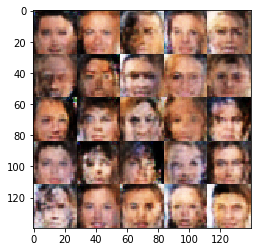

Epoch 1 / 1 G Loss: 0.7127 D Loss: 1.3222
Epoch 1 / 1 G Loss: 0.7421 D Loss: 1.2539
Epoch 1 / 1 G Loss: 0.7901 D Loss: 1.2212
Epoch 1 / 1 G Loss: 0.7506 D Loss: 1.2646
Epoch 1 / 1 G Loss: 0.9237 D Loss: 1.3958
Epoch 1 / 1 G Loss: 0.7081 D Loss: 1.3006
Epoch 1 / 1 G Loss: 0.6152 D Loss: 1.3176
Epoch 1 / 1 G Loss: 0.7649 D Loss: 1.4186
Epoch 1 / 1 G Loss: 0.6796 D Loss: 1.2912
Epoch 1 / 1 G Loss: 0.7840 D Loss: 1.3646


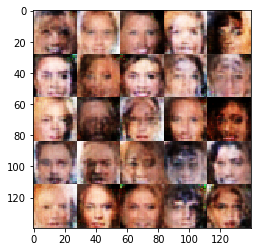

Epoch 1 / 1 G Loss: 0.8480 D Loss: 1.3188
Epoch 1 / 1 G Loss: 0.7320 D Loss: 1.3819
Epoch 1 / 1 G Loss: 0.8072 D Loss: 1.3707
Epoch 1 / 1 G Loss: 0.8497 D Loss: 1.3486
Epoch 1 / 1 G Loss: 0.7126 D Loss: 1.3956
Epoch 1 / 1 G Loss: 0.7037 D Loss: 1.2893
Epoch 1 / 1 G Loss: 0.8264 D Loss: 1.3061
Epoch 1 / 1 G Loss: 0.6285 D Loss: 1.3938
Epoch 1 / 1 G Loss: 0.6830 D Loss: 1.3428
Epoch 1 / 1 G Loss: 0.6693 D Loss: 1.3187


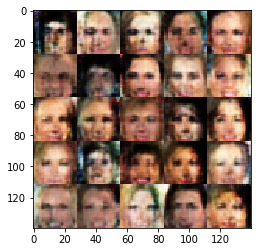

Epoch 1 / 1 G Loss: 0.7908 D Loss: 1.3966
Epoch 1 / 1 G Loss: 0.7142 D Loss: 1.3398
Epoch 1 / 1 G Loss: 0.5340 D Loss: 1.4655
Epoch 1 / 1 G Loss: 0.8506 D Loss: 1.3150
Epoch 1 / 1 G Loss: 0.7313 D Loss: 1.3543
Epoch 1 / 1 G Loss: 0.7184 D Loss: 1.2830
Epoch 1 / 1 G Loss: 0.7475 D Loss: 1.3767
Epoch 1 / 1 G Loss: 0.6829 D Loss: 1.3314
Epoch 1 / 1 G Loss: 0.7880 D Loss: 1.2773
Epoch 1 / 1 G Loss: 0.7004 D Loss: 1.3567


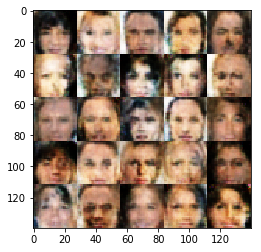

Epoch 1 / 1 G Loss: 0.7225 D Loss: 1.3065
Epoch 1 / 1 G Loss: 0.6314 D Loss: 1.3378
Epoch 1 / 1 G Loss: 0.7205 D Loss: 1.3155
Epoch 1 / 1 G Loss: 0.7282 D Loss: 1.3895
Epoch 1 / 1 G Loss: 0.7817 D Loss: 1.2856
Epoch 1 / 1 G Loss: 0.6256 D Loss: 1.3539
Epoch 1 / 1 G Loss: 0.6756 D Loss: 1.3318
Epoch 1 / 1 G Loss: 0.7545 D Loss: 1.3768
Epoch 1 / 1 G Loss: 0.9110 D Loss: 1.3276
Epoch 1 / 1 G Loss: 0.7912 D Loss: 1.3706


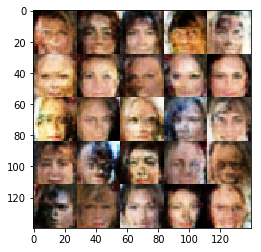

Epoch 1 / 1 G Loss: 0.6737 D Loss: 1.3861
Epoch 1 / 1 G Loss: 0.8951 D Loss: 1.3039
Epoch 1 / 1 G Loss: 0.7427 D Loss: 1.3283
Epoch 1 / 1 G Loss: 0.6878 D Loss: 1.3710
Epoch 1 / 1 G Loss: 0.7638 D Loss: 1.3343
Epoch 1 / 1 G Loss: 0.6914 D Loss: 1.3144
Epoch 1 / 1 G Loss: 0.8645 D Loss: 1.3075
Epoch 1 / 1 G Loss: 0.6415 D Loss: 1.3919
Epoch 1 / 1 G Loss: 0.6861 D Loss: 1.3155
Epoch 1 / 1 G Loss: 0.6746 D Loss: 1.3413


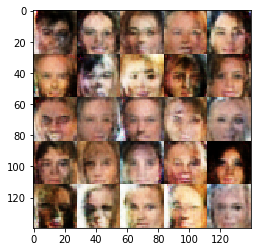

Epoch 1 / 1 G Loss: 0.7435 D Loss: 1.3376
Epoch 1 / 1 G Loss: 0.6717 D Loss: 1.3730
Epoch 1 / 1 G Loss: 0.7927 D Loss: 1.3012
Epoch 1 / 1 G Loss: 0.7599 D Loss: 1.3763
Epoch 1 / 1 G Loss: 0.7664 D Loss: 1.3454
Epoch 1 / 1 G Loss: 0.7253 D Loss: 1.3100
Epoch 1 / 1 G Loss: 0.7946 D Loss: 1.2901
Epoch 1 / 1 G Loss: 0.7137 D Loss: 1.3578
Epoch 1 / 1 G Loss: 0.7642 D Loss: 1.3370
Epoch 1 / 1 G Loss: 0.8723 D Loss: 1.3145


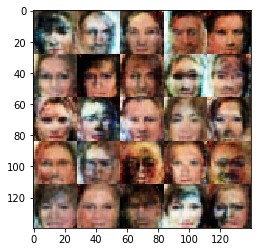

Epoch 1 / 1 G Loss: 0.7457 D Loss: 1.3111
Epoch 1 / 1 G Loss: 0.7985 D Loss: 1.3245
Epoch 1 / 1 G Loss: 0.8102 D Loss: 1.3533
Epoch 1 / 1 G Loss: 0.6366 D Loss: 1.3550
Epoch 1 / 1 G Loss: 0.7139 D Loss: 1.3195
Epoch 1 / 1 G Loss: 0.7213 D Loss: 1.3798
Epoch 1 / 1 G Loss: 0.7551 D Loss: 1.3218
Epoch 1 / 1 G Loss: 0.8158 D Loss: 1.2862
Epoch 1 / 1 G Loss: 0.6952 D Loss: 1.3815
Epoch 1 / 1 G Loss: 0.7153 D Loss: 1.3153


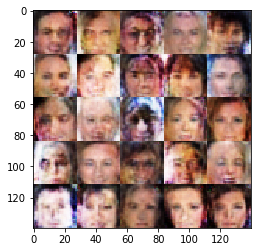

Epoch 1 / 1 G Loss: 0.7616 D Loss: 1.3571
Epoch 1 / 1 G Loss: 0.8402 D Loss: 1.3269
Epoch 1 / 1 G Loss: 0.7509 D Loss: 1.3081
Epoch 1 / 1 G Loss: 0.6166 D Loss: 1.3745
Epoch 1 / 1 G Loss: 0.6386 D Loss: 1.3600
Epoch 1 / 1 G Loss: 0.6518 D Loss: 1.3491
Epoch 1 / 1 G Loss: 0.7902 D Loss: 1.3193
Epoch 1 / 1 G Loss: 0.7242 D Loss: 1.3379
Epoch 1 / 1 G Loss: 0.6537 D Loss: 1.3642
Epoch 1 / 1 G Loss: 0.7474 D Loss: 1.3112


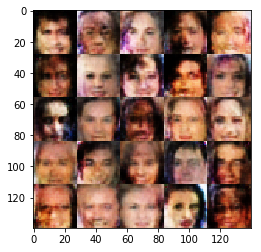

Epoch 1 / 1 G Loss: 0.6763 D Loss: 1.3496
Epoch 1 / 1 G Loss: 0.6489 D Loss: 1.3687
Epoch 1 / 1 G Loss: 0.7690 D Loss: 1.3062
Epoch 1 / 1 G Loss: 0.7761 D Loss: 1.3912
Epoch 1 / 1 G Loss: 0.7404 D Loss: 1.3422
Epoch 1 / 1 G Loss: 0.7883 D Loss: 1.3527
Epoch 1 / 1 G Loss: 0.6809 D Loss: 1.3307
Epoch 1 / 1 G Loss: 0.7150 D Loss: 1.3726
Epoch 1 / 1 G Loss: 0.7648 D Loss: 1.3972
Epoch 1 / 1 G Loss: 0.8515 D Loss: 1.3719


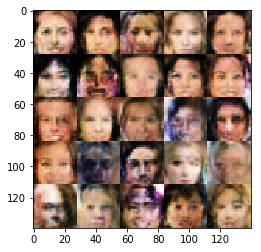

Epoch 1 / 1 G Loss: 0.7364 D Loss: 1.3192
Epoch 1 / 1 G Loss: 0.7212 D Loss: 1.3309
Epoch 1 / 1 G Loss: 0.7928 D Loss: 1.3417
Epoch 1 / 1 G Loss: 0.6905 D Loss: 1.3451
Epoch 1 / 1 G Loss: 0.7416 D Loss: 1.3388
Epoch 1 / 1 G Loss: 0.6862 D Loss: 1.4070
Epoch 1 / 1 G Loss: 0.6295 D Loss: 1.3326
Epoch 1 / 1 G Loss: 0.7070 D Loss: 1.3831
Epoch 1 / 1 G Loss: 0.7032 D Loss: 1.3958
Epoch 1 / 1 G Loss: 0.7167 D Loss: 1.3231


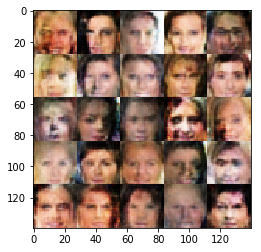

Epoch 1 / 1 G Loss: 0.7754 D Loss: 1.3309
Epoch 1 / 1 G Loss: 0.6804 D Loss: 1.3741
Epoch 1 / 1 G Loss: 0.5899 D Loss: 1.3523
Epoch 1 / 1 G Loss: 0.7730 D Loss: 1.3078
Epoch 1 / 1 G Loss: 0.7379 D Loss: 1.3700
Epoch 1 / 1 G Loss: 0.7374 D Loss: 1.3679
Epoch 1 / 1 G Loss: 0.7458 D Loss: 1.3005
Epoch 1 / 1 G Loss: 0.6687 D Loss: 1.3430
Epoch 1 / 1 G Loss: 0.7525 D Loss: 1.2664
Epoch 1 / 1 G Loss: 0.7409 D Loss: 1.3801


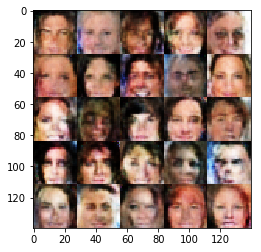

Epoch 1 / 1 G Loss: 0.7870 D Loss: 1.3601
Epoch 1 / 1 G Loss: 0.6746 D Loss: 1.3489
Epoch 1 / 1 G Loss: 0.7402 D Loss: 1.3486
Epoch 1 / 1 G Loss: 0.7282 D Loss: 1.3513
Epoch 1 / 1 G Loss: 0.7237 D Loss: 1.3351
Epoch 1 / 1 G Loss: 0.7004 D Loss: 1.3557
Epoch 1 / 1 G Loss: 0.7457 D Loss: 1.3370
Epoch 1 / 1 G Loss: 0.6596 D Loss: 1.3464
Epoch 1 / 1 G Loss: 0.6608 D Loss: 1.3603
Epoch 1 / 1 G Loss: 0.7375 D Loss: 1.2944


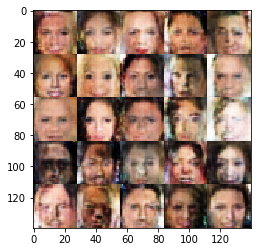

Epoch 1 / 1 G Loss: 0.7808 D Loss: 1.4129
Epoch 1 / 1 G Loss: 0.8212 D Loss: 1.3333
Epoch 1 / 1 G Loss: 0.6523 D Loss: 1.3300
Epoch 1 / 1 G Loss: 0.6998 D Loss: 1.3605
Epoch 1 / 1 G Loss: 0.7526 D Loss: 1.3543
Epoch 1 / 1 G Loss: 0.7078 D Loss: 1.3621
Epoch 1 / 1 G Loss: 0.6991 D Loss: 1.3551
Epoch 1 / 1 G Loss: 0.7641 D Loss: 1.3329
Epoch 1 / 1 G Loss: 0.6828 D Loss: 1.3382
Epoch 1 / 1 G Loss: 0.7477 D Loss: 1.2998


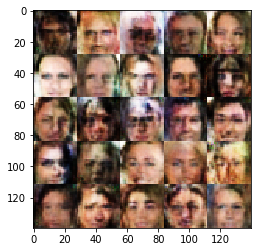

Epoch 1 / 1 G Loss: 0.6743 D Loss: 1.3381
Epoch 1 / 1 G Loss: 0.6710 D Loss: 1.3508
Epoch 1 / 1 G Loss: 0.6711 D Loss: 1.3755
Epoch 1 / 1 G Loss: 0.7645 D Loss: 1.3350
Epoch 1 / 1 G Loss: 0.7550 D Loss: 1.3434
Epoch 1 / 1 G Loss: 0.7030 D Loss: 1.3421


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
ALPHA = 0.2
SHOW_EVERY = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.